# Strategy types
The FiMDP package offers several solvers that can generate strategies for the considered objectives. In this notebook, we focus on the Büchi objective and discuss solvers that all:
 * solve almost-sure Büchi objective and
 * compute the minimal initial load needed in each state.
In other words, all the solvers have the same guarantees. Where they differ are the strategies they produce. Our overall goal is to provide strategies that not only provide these guarantees but are also **usable in practical control case studies**.

We use a simple gridworld underwater environment generated by [FiMDPEnv] to demonstrate the behavior we can obtain using different solvers of the [FiMDP] package. We have some pre-defined environments in the file [env.py](env.py). The goal of the agent is to reach the green target with sufficient energy so that it can reach it again and again.

In each cell of the gridworld, the agent can choose one of eight possible actions. For each of the 4 directions (`NORTH`, `SOUTH`, `WEST`, `EAST`) the agent chooses whether to play a *weak* or _strong_ action. A strong action costs more energy, while the weak action has uncertain outcome. The resulting direction of movement can be affected by pre-defined currents. For example, in most cases, picking `EAST` can, with a small probability end up with the agent going `SOUTH` or `NORTH`.

[FiMDP]: https://github.com/xblahoud/FiMDP
[FiMDPEnv]: https://github.com/pthangeda/FiMDPEnv

In [1]:
import fimdpenv

In [2]:
fimdpenv.setup()
from env import create_env

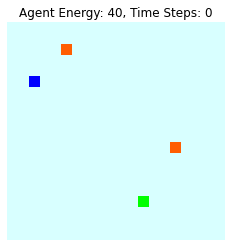

In [3]:
e = create_env('2R-1T-simple', heading_sd=0.32, agent_capacity=40)
e

The colors of the gridworld cells have the following semantics:
 * <font color='blue'>Blue Cell</font>: Current location of the agent
 * <font color='gray'>Gray Cells</font>: Trajectory of the agent
 * <font color='green'>Green Cells</font>: Target States
 * <font color='orange'>Orange Cells</font>: Reload states

This package offers 2 solvers that generate strategies:
 * Basic solver (class `BasicES`)
 * Goal-leaning solver (class `GoalLeaningES`)

In [4]:
import fimdp
fimdp.setup()

def showcase_solver(SolverClass, gw=e, steps=100, capacity=40):
    gw.agent_capacity=capacity
    m, t = gw.get_consmdp()
    solver = SolverClass(m, capacity, t)
    strategy = solver.get_selector(fimdp.objectives.BUCHI)
    return gw.animate_strategy(strategy, num_steps=steps)
    
def strategy_at(SolverClass, state, gw=e, steps=100, capacity=40):
    gw.agent_capacity=capacity
    m, t = gw.get_consmdp()
    solver = SolverClass(m, capacity, t)
    strategy = solver.get_selector(fimdp.objectives.BUCHI)
    return strategy[state]

## Basic solver
Let's first look at what happens when we apply the algorithm from our [work] presented at [CAV'2020] without any modification on our problem.

The basic algorithm does not take probabilities of outcomes into account at all. This is a standard approach in quantitative algorithms for MDPs.

[CAV'2020]: https://i-cav.org/2020/
[work]: https://doi.org/10.1007/978-3-030-53291-8_22

In [5]:
from fimdp.energy_solvers import BasicES
showcase_solver(BasicES, capacity=40)

While the generated strategy guarantees that the agent eventually reaches the target with probability 1, it might take an enourmous number of steps before it really happens. As the basic solver does ignore probabilities of action-outcomes complete, all actions with `WEST` as a possible outcome to `WEST` are equally good. The order of actions processed by the algorithm starts with `NORTH`, and thus `NORTH` is often chosen instead of `EAST`. But the agent only moves to `EAST` on rare events.

In [6]:
reload = e.consmdp.reloads.index(True)
strategy_at(BasicES, reload, capacity=40)

{0: 45——[45, 0][1]——>{25: 0.983, 44: 0.003, 46: 0.014}}

Above, we can see that for all values of energy, the strategy chooses action labeled `[45, 0]` in the reload state. The `45` is the id of the reload state, and `0` stands for `NORTH`.

## Goal-leaning solver
The goal-leaning solver aims to solve the issue of the *Basic solver*. It does not ignore the probabilities on edges. 

When choosing from equally good actions, this solver chooses the most-likely successful action.

#### More technical explenation
The measure of *goodness* in the sentence above means *low value of `action_value_T`, which is the amount of energy needed to satisfy the objective*. The `action_value_T` is $\mathit{SPR-Val}$ in the CAV paper. In contrast with the Basic solver, `action_value_T` returns not only the action value, but also the probability that the outcome of this action will the one that produced this value. Then from actions with minimal value we choose the one with the highest probability of reaching the desired outcome.

In [7]:
from fimdp.energy_solvers import GoalLeaningES
showcase_solver(GoalLeaningES, capacity=40)

In [8]:
strategy_at(GoalLeaningES, reload, capacity=40)

{0: 45——[45, 1][1]——>{44: 0.003, 46: 0.019, 65: 0.978}}

This looks much better. We can see that now the picked action is `[45, 1]`, where `1` translates to `EAST`. 

However, in certain situations, strategies generated by the Goal-leaning solver do not work well. Consider the following scenario with capacity that is slightly lower.

In [9]:
showcase_solver(GoalLeaningES, capacity=35)

The reason why the agent does not pick `EAST` when being in the half on his route is that `EAST` is not among the actions with the lowest value. The higher value is caused by $\mathit{Safe}$-value for `SOUTH`, which is a possible outcome of `EAST`. Intuitively, $\mathit{Safe}$-value of a state is the minimum level of energy needed to survive from this state and in our scenario it loosely translates to distance from reload states. These values of all possible outcomes also influence the `action_value_T`. In the case above, all possible outcomes of the action `NORTH` have lower $\mathit{Safe}$-value than the state `SOUTH` and thus all actions with `SOUTH` as a possible outcome are disregarded by this solver. As a result, `NORTH` is the only action considered and even though the desired outcome (`EAST` in this case) has a low probability, `NORTH` is the winner.

In [10]:
problematic = 187
strategy_at(GoalLeaningES, problematic)

{28: 187——[187, 1][1]——>{186: 0.003, 188: 0.019, 207: 0.978},
 18: 187——[187, 0][1]——>{167: 0.983, 186: 0.003, 188: 0.014},
 16: 187——[187, 4][2]——>{167: 1.0}}

This is the strategy at the problematic spot. We can see, that with energy between 18 and 27, the agent picks `0`, which is `NORTH`. The agent with capacity 35 can only reach this spot from the top reload state with capacity 26, which is in this interval. With 40, the energy 31 is feasible in this spot and thus we did not see such behavior.

### Thresholds

We can overcome the issue from above by introducing a threshold on desired outcomes of actions it considers. Loosely speaking, when computing `action_value_T`, we disregard possible outcomes that are less likely than the given threshold. As a result, it only considers `NORTH` as the desired outcome of action `NORTH` when computing `action_value_T`.

Ignoring the rare cases can lead to an increase in the minimal energy we need to satisfy the objective. For example, in the problematic case above, `NORTH` will have higher `action_value_T` with the threshold, which means that its previous value is no longer achieved. Therefore, after reaching the fixpoint for the first time (using the threshold-approach), we run another fixpoint that can improve the current values not using the threshold.

In [11]:
threshold_class = lambda mdp, cap, t: GoalLeaningES(mdp, cap, t, threshold=0.1)
showcase_solver(threshold_class, capacity=35)

In [12]:
problematic = 187
strategy_at(threshold_class, problematic, capacity=35)

{28: 187——[187, 1][1]——>{186: 0.003, 188: 0.019, 207: 0.978},
 19: 187——[187, 6][2]——>{188: 1.0},
 16: 187——[187, 4][2]——>{167: 1.0}}

This strategy uses the strong actions (`4`—`7`) for energy between 16 and 27. It goes `NORTH=4` only with interval 16—18, and prefers to go to `SOUTH=6` with energy in 19—28, and finally uses weak action to `EAST` with more than 27 units of energy.

## Equivalent values

In this section, we show that the new solvers are actually improving the Basic solver while maintaining the same minimal energy levels needed to fulfill the objectives. These values can be obtained by calling the `get_min_levels(BUCHI)` on the solvers.

In [13]:
from fimdp.objectives import BUCHI

In [14]:
m, t = e.get_consmdp()
basic = BasicES(m, cap=35, targets=t)
goal = GoalLeaningES(m, cap=35, targets=t)
threshold = GoalLeaningES(m, cap=35, targets=t, threshold=0.1)

In [15]:
assert basic.get_min_levels(BUCHI) == goal.get_min_levels(BUCHI), ("The basic and goal-leaning strategy "+
                                              "do not reach the same values of "+
                                              "initial load for the same task.")
print("Passed test 1 for values of goal-leaning strategies in file tut/Solvers.ipynb")
assert basic.get_min_levels(BUCHI) == threshold.get_min_levels(BUCHI), ("The basic and the threshold strategy "+
                                              "do not reach the same values of "+
                                              "initial load for the same task.")
print("Passed test 2 for values of goal-leaning strategies in file tut/Solvers.ipynb")

Passed test 1 for values of goal-leaning strategies in file tut/Solvers.ipynb
Passed test 2 for values of goal-leaning strategies in file tut/Solvers.ipynb


## Interesting cases

### Sure path with 2 steps better than unlikely 1-step path.

![threshold example](threshold_example.svg)

All actions having consumption 1, not-listed probabilities are also 1, rel are reload states.

Now let's create the CMDP using the FiMDP package.

In [16]:
from fimdp.examples.reachability_examples import two_step
mdp, T = two_step()

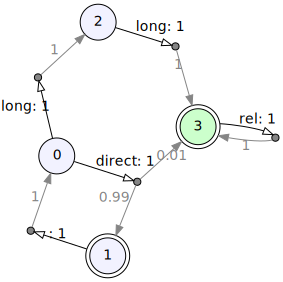

In [17]:
basic = BasicES(mdp, cap=40, targets=T)
goal = GoalLeaningES(mdp, cap=40, targets=T)
threshold = GoalLeaningES(mdp, cap=40, targets=T, threshold=0.011)
basic.show()

Intuitively, if we want to reach the target quickly, we need to take the upper path (via state 2) and we surely reach the target (double circled) in 2 steps. The lower path (via state 1) reaches the target with very low probability; trying infinitely often will lead us to the target almost surely, though.

The basic solver chooses the action `direct` that goes to the lower state. The same holds for the goal-leaning solver. With the threshold being $> 0.01$ the threshold solver goes via the lower path only with energy=1 (using the below-threshold value from the second fix-point), otherwise, it prefers the upper path.

In [18]:
basic.get_selector(BUCHI)

[{1: 0——direct[1]——>{1: 0.99, 3: 0.01}},
 {0: 1——[1]——>{0: 1}},
 {1: 2——long[1]——>{3: 1}},
 {1: 3——rel[1]——>{3: 1}}]

In [19]:
goal.get_selector(BUCHI)

[{1: 0——direct[1]——>{1: 0.99, 3: 0.01}},
 {0: 1——[1]——>{0: 1}},
 {1: 2——long[1]——>{3: 1}},
 {1: 3——rel[1]——>{3: 1}}]

In [20]:
threshold.get_selector(BUCHI)

[{2: 0——long[1]——>{2: 1}, 1: 0——direct[1]——>{1: 0.99, 3: 0.01}},
 {0: 1——[1]——>{0: 1}},
 {1: 2——long[1]——>{3: 1}},
 {1: 3——rel[1]——>{3: 1}}]

In [21]:
result = {k: v.label for k, v in threshold.get_selector(BUCHI)[0].items()}
expected = {2: 'long', 1: 'direct'}
assert result == expected, ("The threshold strategy should return\n" +
                           f"{expected} in state 0.\n" +
                           f"{result} returned in 0.")
print("Passed test 3 for the threshold strategy in file tut/Solvers.ipynb")

Passed test 3 for the threshold strategy in file tut/Solvers.ipynb


### Simple goal-leaning example

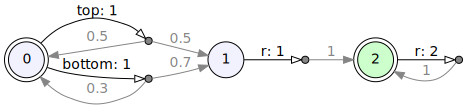

In [22]:
from fimdp.examples.reachability_examples import goal_leaning
gl, T = goal_leaning()

basic = BasicES(gl, 10, targets=T)
goal = GoalLeaningES(gl, 10, targets=T)
goal.show()

In state 0, the standard solver (`basic`) chooses the `top` action because it is processed first and `bottom` does not yield any better value. You can change the order of the actions in the function that creates the CMDP and see that the result for `basic` changes.

The goal-leaning solver, however, chooses `bottom` as it yields a higher probability of reaching the state 1, which is the successor that has good promise to reach a target.

In [23]:
print(basic.get_selector(BUCHI), goal.get_selector(BUCHI), sep="\n")

[{0: 0——top[1]——>{1: 0.5, 0: 0.5}}, {1: 1——r[1]——>{2: 1}}, {2: 2——r[2]——>{2: 1}}]
[{0: 0——bottom[1]——>{1: 0.7, 0: 0.3}}, {1: 1——r[1]——>{2: 1}}, {2: 2——r[2]——>{2: 1}}]


In [24]:
result = goal.get_selector(BUCHI)[0][0].label
expected = 'bottom'
assert result == expected, (
    f"The goal-leaning strategy should prefer the action `{expected}` " +
    f"in state 0. It chooses `{result}` instead."
)
print("Passed test 4 for goal-leaning solver in file tut/Solvers.ipynb")

Passed test 4 for goal-leaning solver in file tut/Solvers.ipynb


### Goal-leaning is just a heuristic
We slightly modify the previous example by adding a new state (3), which is a copy of state 1. The `top` action, now named `sure`, does not loop back to 0, instead, it goes either to 1 or 2. This results in a situation where picking the `sure` action surely leads to the targets. But when deciding which action to choose, the solvers always consider only 1 successor. The best the action `sure` can achieve in this view is `0.5` reaching a promising successor. Therefore, the goal-leaning solver still prefers the bottom action, now called `cycle`. The `basic` solver still chooses the action that comes first as they both can achieve the same value.

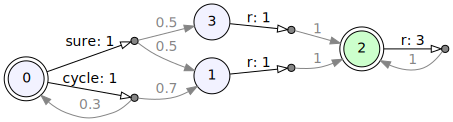

In [25]:
from fimdp.examples.reachability_examples import goal_leaning_2
gl2, T = goal_leaning_2()

basic2 = BasicES(gl2, 10, targets=T)
goal2 = GoalLeaningES(gl2, 10, targets=T)
goal2.show()

In [26]:
print(basic2.get_selector(BUCHI), goal2.get_selector(BUCHI), sep="\n")

[{0: 0——sure[1]——>{1: 0.5, 3: 0.5}}, {1: 1——r[1]——>{2: 1}}, {3: 2——r[3]——>{2: 1}}, {1: 3——r[1]——>{2: 1}}]
[{0: 0——cycle[1]——>{1: 0.7, 0: 0.3}}, {1: 1——r[1]——>{2: 1}}, {3: 2——r[3]——>{2: 1}}, {1: 3——r[1]——>{2: 1}}]
